### European Fashion E-commerce - EDA
In this notebook I'm going to explore the dataset, to understand the structure, check distributions, relations between variables and highlight key patterns before building any dashboard.

In [ ]:
# libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# 1) Excel
df = pd.read_excel("Master_final.xlsx", sheet_name="master_clean_final")

# 2) dataframe
dfw = df[[
    "Revenue",
    "Category",
    "Country",
    "Discount",
    "Channel",
    "Age range",
    "Quantity",
    "Unit Price",
]].copy()

# 3) Names
dfw.columns = [
    "revenue","category","country","discount","channel",
    "age range","quantity","unit price","original price"
]

# 4) force numeric types where needed
for c in ["revenue","discount","quantity","unit price","original price"]:
    dfw[c] = pd.to_numeric(dfw[c], errors="coerce")

dfw.head()

,revenue,category,country,discount,channel,age range,quantity,unit price,original price
0,232.60,Pants,GERMANY,0,E-commerce,46-55,5,46.52,46.52
1,232.05,Sleepwear,FRANCE,0,E-commerce,36-45,5,46.41,46.41
2,230.50,T-Shirts,PORTUGAL,0,App Mobile,46-55,5,46.10,46.10
3,230.45,Pants,SPAIN,0,E-commerce,16-25,5,46.09,46.09
4,230.35,Dresses,FRANCE,0,E-commerce,46-55,5,46.07,46.07


# Dataset overview
I print size, column names,types and quick quiality checks. This matches the structure in the example but stays minimal.

In [ ]:
print("Shape:", dfw.shape)
print("\nColumns:", list(dfw.columns))
print("\nDtypes:")
print(dfw.dtypes)

# missing values
missing = (dfw.isna().sum() / len(dfw) * 100).sort_values(ascending=False)
print("\nMissing values (%):")
print(missing)

# duplicates
print("\nDuplicate rows:", dfw.duplicated().sum())

# revenue sanity
if "revenue" in dfw.columns:
    print("\nRevenue min/max:", dfw["revenue"].min(), dfw["revenue"].max())

Shape: (2193, 6)

Columns: ['revenue', 'category', 'country', 'discount', 'channel', 'age range']

Dtypes:
revenue      float64
category      object
country       object
discount       int64
channel       object
age range     object
dtype: object

Missing values (%):
revenue      0.0
category     0.0
country      0.0
discount     0.0
channel      0.0
age range    0.0
dtype: float64

Duplicate rows: 10

Revenue min/max: 20.82 400.0


# Step 1 - Histogram
In this step, I look at revenue distribution and the top values. Since I have few products, I will keep visuals small and readeble



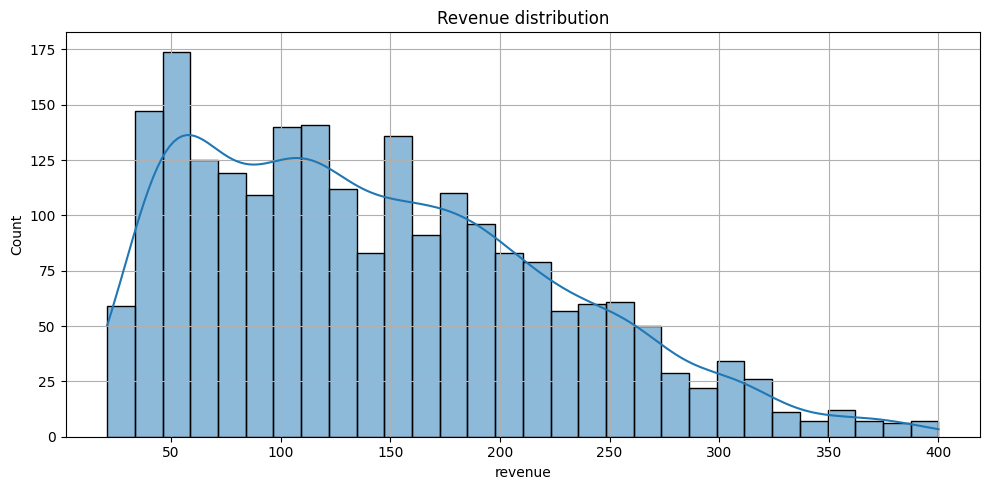


Top values for category:
category
T-Shirts     477
Dresses      471
Shoes        458
Sleepwear    445
Pants        342
Name: count, dtype: int64

Top values for country:
country
GERMANY        522
FRANCE         477
ITALY          400
NETHERLANDS    324
SPAIN          271
PORTUGAL       199
Name: count, dtype: int64

Top values for channel:
channel
E-commerce    1151
App Mobile    1042
Name: count, dtype: int64

Top values for age range:
age range
36-45    467
26-35    447
16-25    437
46-55    426
56-65    416
Name: count, dtype: int64


In [ ]:
# revenue distribution
if "revenue" in dfw.columns:
    sns.histplot(dfw["revenue"].dropna(), bins=30, kde=True)
    plt.title("Revenue distribution")
    plt.tight_layout()
    plt.show()

# top counts for small-N columns
for col in [c for c in ["product","category","country","channel","age range"] if c in dfw.columns]:
    print(f"\nTop values for {col}:")
    print(dfw[col].value_counts(dropna=False))

## Step 2 - KPIs
I sum revenue by:
- Product or category.
- Country
- Channel
- Age range

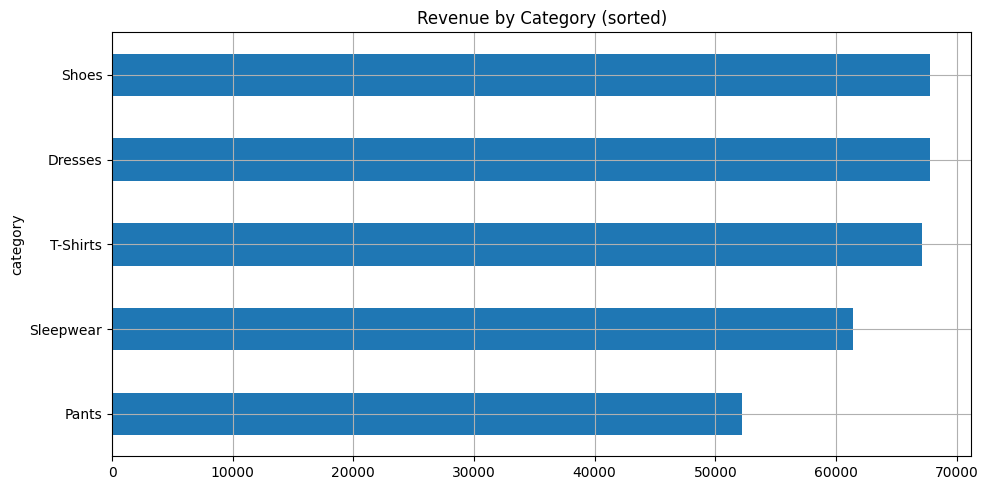

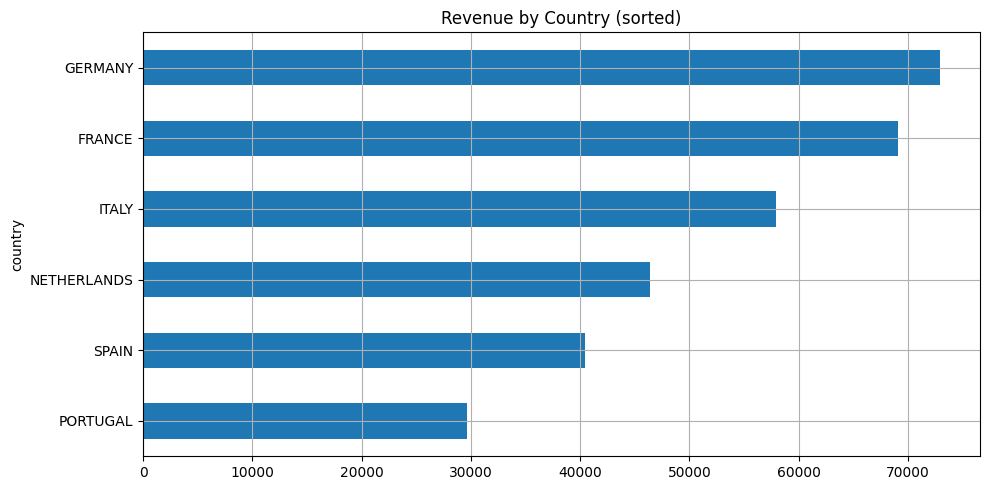

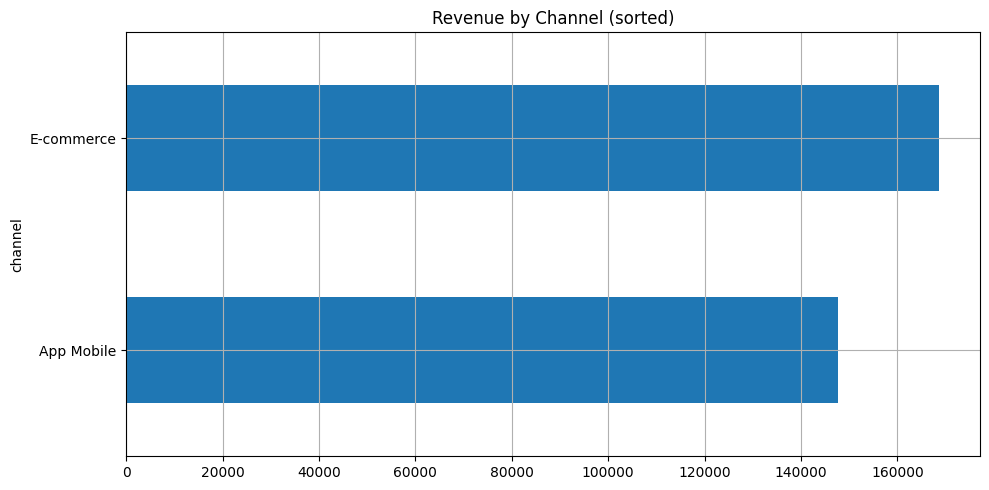

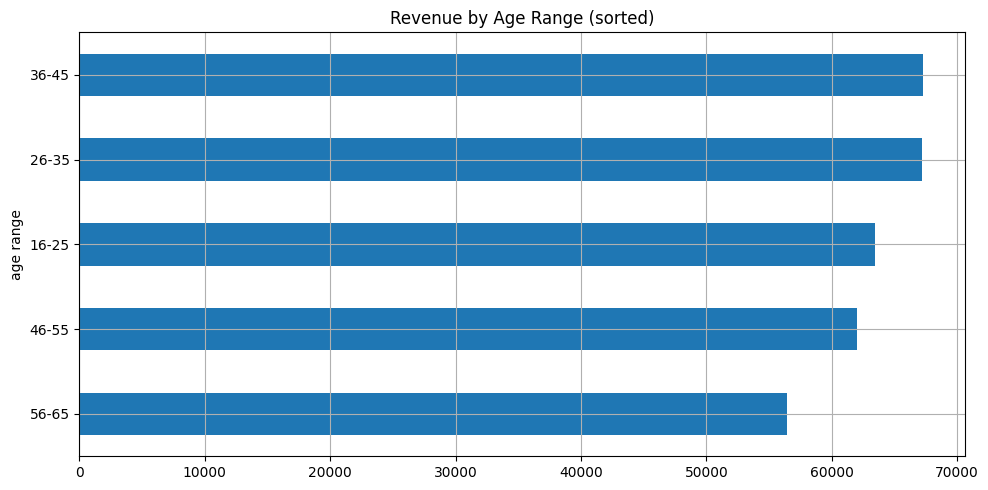

In [ ]:
def bar_sorted(series, title, rotate=25):
    s = series.sort_values(ascending=True)  # small-N
    s.plot(kind="barh")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# product/category
if {"revenue","product"}.issubset(dfw.columns):
    by_prod = dfw.groupby("product", dropna=False)["revenue"].sum()
    bar_sorted(by_prod, "Revenue by Product (sorted)")
elif {"revenue","category"}.issubset(dfw.columns):
    by_cat = dfw.groupby("category", dropna=False)["revenue"].sum()
    bar_sorted(by_cat, "Revenue by Category (sorted)")

# country
if {"revenue","country"}.issubset(dfw.columns):
    by_country = dfw.groupby("country", dropna=False)["revenue"].sum()
    bar_sorted(by_country, "Revenue by Country (sorted)")

# channel
if {"revenue","channel"}.issubset(dfw.columns):
    by_channel = dfw.groupby("channel", dropna=False)["revenue"].sum()
    bar_sorted(by_channel, "Revenue by Channel (sorted)")

# age range
if {"revenue","age range"}.issubset(dfw.columns):
    # try to order age bands naturally by first number
    import re
    def age_key(v):
        nums = re.findall(r"\d+", str(v))
        return int(nums[0]) if nums else 10**9
    by_age = dfw.groupby("age range", dropna=False)["revenue"].sum()
    by_age = by_age.sort_index(key=lambda idx: [age_key(v) for v in idx])
    bar_sorted(by_age, "Revenue by Age Range (sorted)")

### Step 3 - Key questions

1.   Best vs. Worst items
2.   Top countries
3.   Correlation between discount and revenue
4.   Channels


Revenue and share by category:


,revenue,share
category,,
Shoes,67830.43,0.214
Dresses,67809.11,0.214
T-Shirts,67143.29,0.212
Sleepwear,61386.06,0.194
Pants,52213.66,0.165


Revenue and share by country:


,revenue,share
country,,
GERMANY,72945.79,0.231
FRANCE,69097.09,0.218
ITALY,57880.42,0.183
NETHERLANDS,46423.77,0.147
SPAIN,40431.40,0.128
PORTUGAL,29604.08,0.094


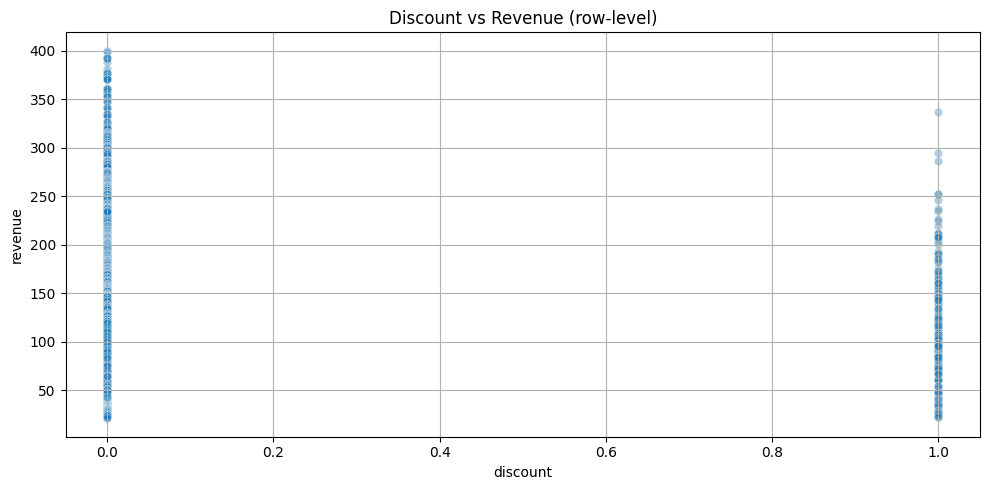

Global correlation (discount vs revenue): -0.13
Revenue and share by channel:


,revenue,share
channel,,
E-commerce,168690.12,0.533
App Mobile,147692.43,0.467


In [ ]:
# 1) all categories
by_cat = by_cat.sort_values(ascending=False)
cat_total = by_cat.sum()
cat_table = pd.DataFrame({"revenue": by_cat, "share": (by_cat / cat_total).round(3)})
print("Revenue and share by category:")
display(cat_table)

# 2) countries
by_country = by_country.sort_values(ascending=False)
ctry_total = by_country.sum()
ctry_table = pd.DataFrame({"revenue": by_country, "share": (by_country / ctry_total).round(3)})
print("Revenue and share by country:")
display(ctry_table)

# 3) discount effect (scatter + simple correlation)
sns.scatterplot(data=dfw, x="discount", y="revenue", alpha=0.35)
plt.title("Discount vs Revenue (row-level)")
plt.tight_layout(); plt.show()

corr = dfw[["discount","revenue"]].corr(numeric_only=True).iloc[0,1]
print(f"Global correlation (discount vs revenue): {corr:.2f}")

# 4) channels with share
by_channel = by_channel.sort_values(ascending=False)
chn_total = by_channel.sum()
chn_table = pd.DataFrame({"revenue": by_channel, "share": (by_channel / chn_total).round(3)})
print("Revenue and share by channel:")
display(chn_table)

Revenue and share by item:


,revenue,share
category,,
Shoes,67830.43,0.214
Dresses,67809.11,0.214
T-Shirts,67143.29,0.212
Sleepwear,61386.06,0.194
Pants,52213.66,0.165


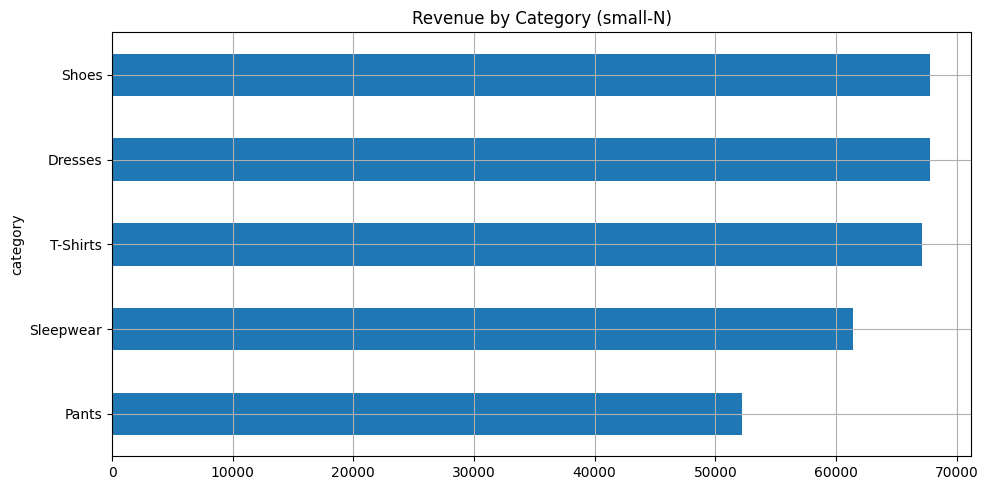

In [ ]:
item_dim = "product" if "product" in dfw.columns else ("category" if "category" in dfw.columns else None)

if item_dim and "revenue" in dfw.columns:
    by_item = dfw.groupby(item_dim, dropna=False)["revenue"].sum().sort_values(ascending=False)
    total = by_item.sum()
    small = pd.DataFrame({
        "revenue": by_item,
        "share": (by_item / total).round(3)
    })
    print("Revenue and share by item:")
    display(small)

    # small bar
    bar_sorted(by_item, f"Revenue by {item_dim.title()} (small-N)")

Revenue and share by country:


,revenue,share
country,,
GERMANY,72945.79,0.231
FRANCE,69097.09,0.218
ITALY,57880.42,0.183
NETHERLANDS,46423.77,0.147
SPAIN,40431.40,0.128
PORTUGAL,29604.08,0.094


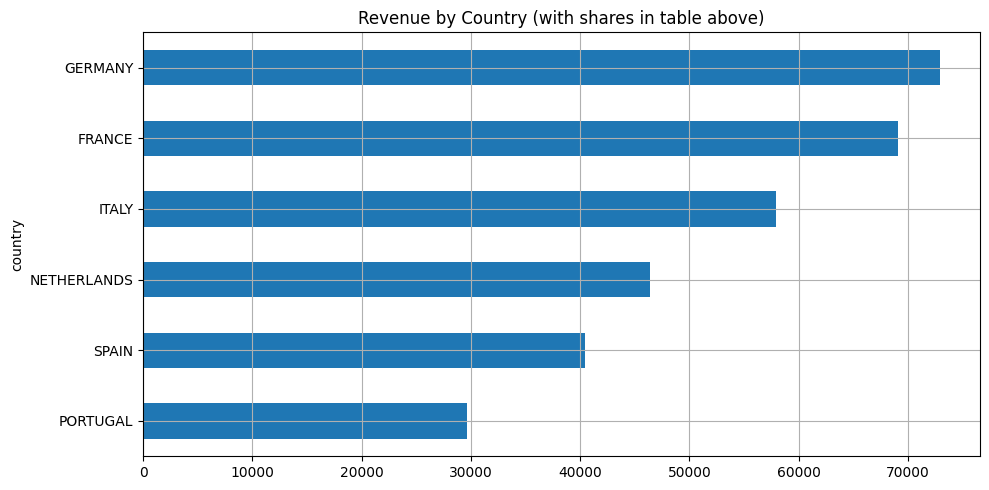

In [ ]:
if {"revenue","country"}.issubset(dfw.columns):
    by_country = dfw.groupby("country", dropna=False)["revenue"].sum().sort_values(ascending=False)
    total = by_country.sum()
    small = pd.DataFrame({
        "revenue": by_country,
        "share": (by_country / total).round(3)
    })
    print("Revenue and share by country:")
    display(small)

    bar_sorted(by_country, "Revenue by Country (with shares in table above)")

In [ ]:
def segment_corr(df, segment_col, x="discount", y="revenue"):
    need = {segment_col, x, y}
    if not need.issubset(df.columns):
        return pd.DataFrame(columns=[segment_col,"corr_value"])
    d = df.dropna(subset=[segment_col, x, y]).copy()
    out = (
        d.groupby(segment_col)
         .apply(lambda g: g[y].corr(g[x]))
         .reset_index(name="corr_value")
    )
    out = out.reindex(out["corr_value"].abs().sort_values(ascending=False).index)
    return out

# Example: by category
if {"category","discount","revenue"}.issubset(dfw.columns):
    corr_by_cat = segment_corr(dfw, "category")
    print("Correlation by category:")
    display(corr_by_cat)

Correlation by category:


/var/folders/l2/l5cbn0l91s51rkbk4h30yrxr0000gn/T/ipykernel_72159/2047735113.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  d.groupby(segment_col)


,category,corr_value
0,Dresses,-0.166072
3,Sleepwear,-0.154060
4,T-Shirts,-0.140376
2,Shoes,-0.107753
1,Pants,-0.089669


Revenue and share by channel:


,revenue,share
channel,,
E-commerce,168690.12,0.533
App Mobile,147692.43,0.467


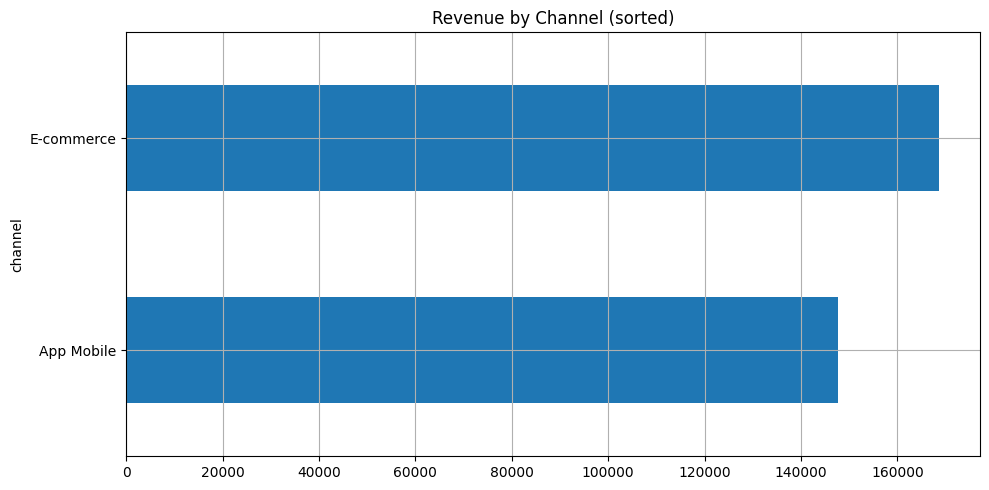

In [ ]:
if {"revenue","channel"}.issubset(dfw.columns):
    by_channel = dfw.groupby("channel", dropna=False)["revenue"].sum().sort_values(ascending=False)
    total = by_channel.sum()
    print("Revenue and share by channel:")
    display(pd.DataFrame({"revenue": by_channel, "share": (by_channel/total).round(3)}))
    bar_sorted(by_channel, "Revenue by Channel (sorted)")

# Step 4 - Correlation map


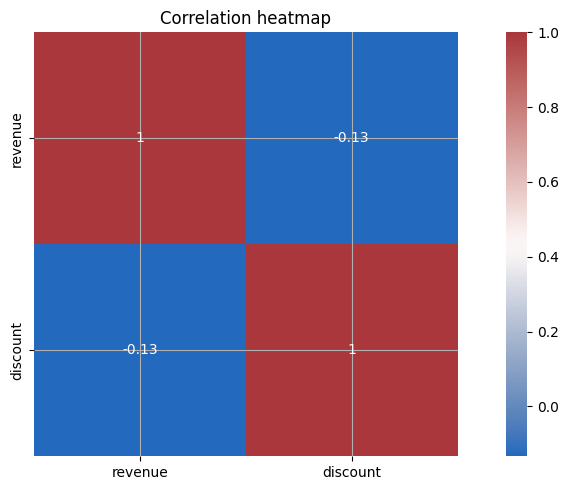

In [ ]:
num_cols = [c for c in ["revenue","discount","price","quantity"] if c in dfw.columns]
if len(num_cols) >= 2:
    corr = dfw[num_cols].corr(numeric_only=True)
    sns.heatmap(corr, annot=True, cmap="vlag", square=True)
    plt.title("Correlation heatmap")
    plt.tight_layout(); plt.show()
else:
    print("Not enough numeric columns for a heatmap.")